#Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense,Dropout, Activation, GRU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.backend import binary_crossentropy
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Load and Prepare data

In [ ]:
# Load the dataset
data_df = pd.read_csv("/content/drive/MyDrive/Mini_Project/GR_BERT+ LSTM/Deep Learning/raw_data_embeddings_final.csv")
embeddings = data_df.iloc[:, 0:768].values
sentences = data_df["title"].values
labels = data_df["target"].values
scaler = MinMaxScaler()
embeddings = scaler.fit_transform(embeddings)

X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


# Reshape the input data
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

In [ ]:
data_df.head()
data_df.info

<bound method DataFrame.info of              0         1         2         3         4         5         6  \
0    -0.031638  0.328281  0.333522  0.660566 -0.184073 -0.306779  0.973271   
1     0.549243  0.186659  0.274203  0.212183 -0.254601 -0.281766  0.998770   
2     0.330395 -0.469188  0.170782  0.741515  0.530469  0.346344  0.985434   
3    -0.157270  0.738068  0.374261  0.734117  0.255580 -0.192853  0.996995   
4    -0.213233  0.101094  0.623188  0.828470 -0.667086  0.144473  0.993830   
...        ...       ...       ...       ...       ...       ...       ...   
3355 -0.250883 -0.553057  0.291805  0.963564  0.491366  0.323621  0.852856   
3356 -0.409841 -0.643344  0.353969  0.851726  0.522653  0.494000  0.978380   
3357 -0.393580 -0.233479 -0.134582  0.045005  0.019850  0.177250  0.934787   
3358  0.119813  0.478237  0.289512  0.576391  0.017050  0.305005  0.989733   
3359  0.196455 -0.175018  0.164153  0.702428  0.023903  0.410728  0.985416   

             7         8       

#Functions

In [ ]:
def callbacks(name):
  """
  EarlyStoping:Stop training when a monitored metric (here: loss) has stopped improving
  ReduceLROnPlateau class: reduces the learning rate when a metric (here: loss) has stopped improving
  ModelCheckpoint: saves the best model based on loss at the specified filepath
 """
  return [
        EarlyStopping(monitor = 'loss', patience = 6),
        ReduceLROnPlateau(monitor = 'loss', patience = 3),
        ModelCheckpoint(f'/content/drive/MyDrive/Mini_Project/GR_BERT+ LSTM/{name}.hdf5', save_best_only=True) # saving the best model
    ]

# A function that plots the Loss and Accuracy

def show_train_history(train_history, name):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_history.history['loss'], label='Training Loss')
    plt.plot(train_history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_history.history['accuracy'], label='Training Accuracy')
    plt.plot(train_history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'/content/drive/MyDrive/Mini_Project/GR_BERT+ LSTM/{name}.png')
    plt.show()

# A function that computes the accuracy and the confusion matrix of a model and prints the classification report
def evaluate_results(model, X_test, y_test):
    # Evaluate the model's performance using the accuracy
    accuracy = model.evaluate(X_test, y_test, verbose=1)
    print('Model evaluation:', accuracy)
    print()

    # Obtain predicted labels
    y_pred = model.predict(X_test)
    y_pred_classes = np.round(y_pred).flatten().astype(int)

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)

    # Plot confusion matrix as heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title('Confusion Matrix')
    plt.show()
    print()

    # Print classification report
    print('Classification report of Confusion matrix:\n', classification_report(y_test, y_pred_classes))

#Bi-LSTM

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 64)               205056    
 l)                                                              
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                        

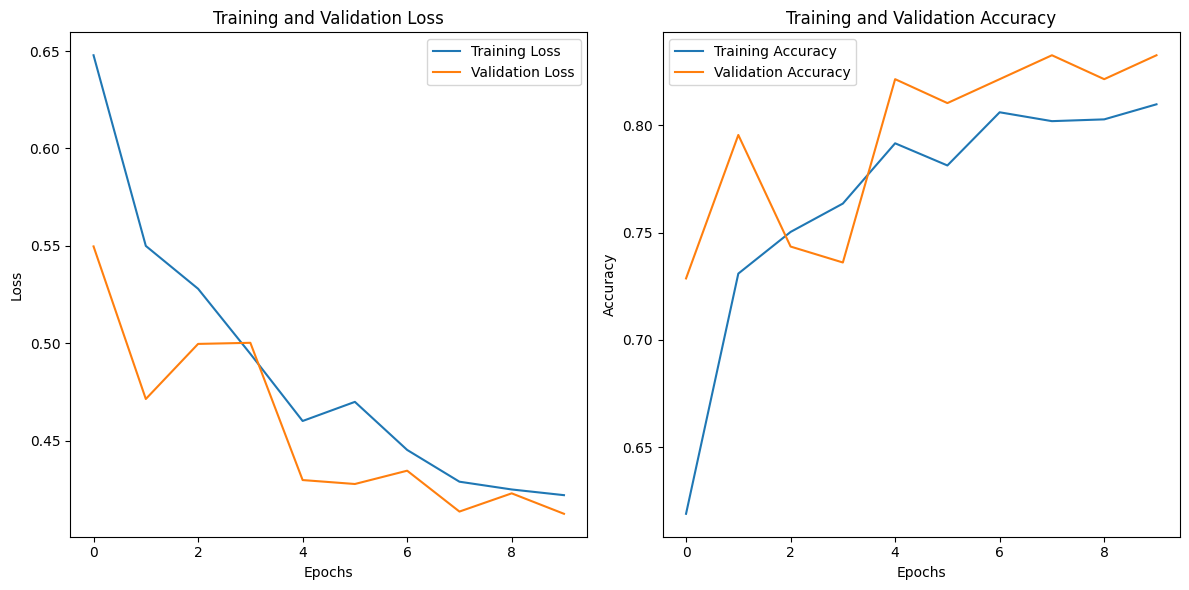

In [ ]:
def get_bi_lstm():
  """
  Sequential: means that each layer has exactly one input answer and one output answer
  Dropout:Regularization method:  30% of the neurons will be deactivated during training. Prevents the overfitting of the network.
  """
  return Sequential([
      Bidirectional(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2), input_shape=(1, 768)),
      Dense(256, activation='relu'),
      Dense(128, activation='relu'),
      Dropout(0.3),
      Dense(10, activation='relu'),
      Dense(1, activation='sigmoid')
])

bi_lstm_model=get_bi_lstm()
bi_lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
bi_lstm_model.summary()
history_bi_lstm=bi_lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val),callbacks = callbacks('biLSTM'))
show_train_history(history_bi_lstm, name='bi-lstm')


#Evaluate Bi-LSTM

21/21 [==============================] - 0s 6ms/step - loss: 0.3900 - accuracy: 0.8080
Model evaluation: [0.3900197446346283, 0.8080357313156128]

21/21 [==============================] - 0s 3ms/step


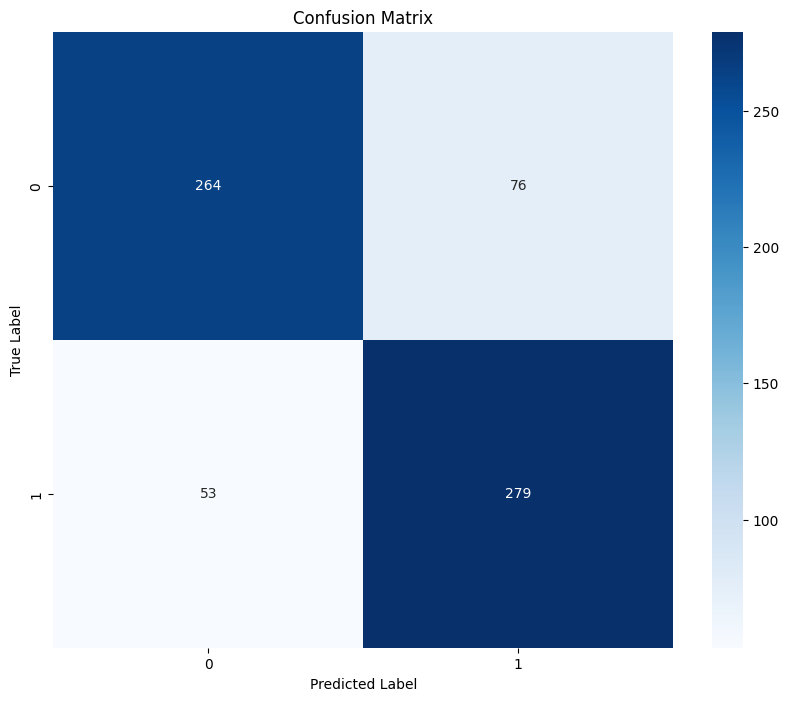


Classification report of Confusion matrix:
               precision    recall  f1-score   support

           0       0.83      0.78      0.80       340
           1       0.79      0.84      0.81       332

    accuracy                           0.81       672
   macro avg       0.81      0.81      0.81       672
weighted avg       0.81      0.81      0.81       672



In [ ]:
evaluate_results(bi_lstm_model, X_test, y_test)

#Bi-GRU

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 1, 256)           689664    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              123648    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

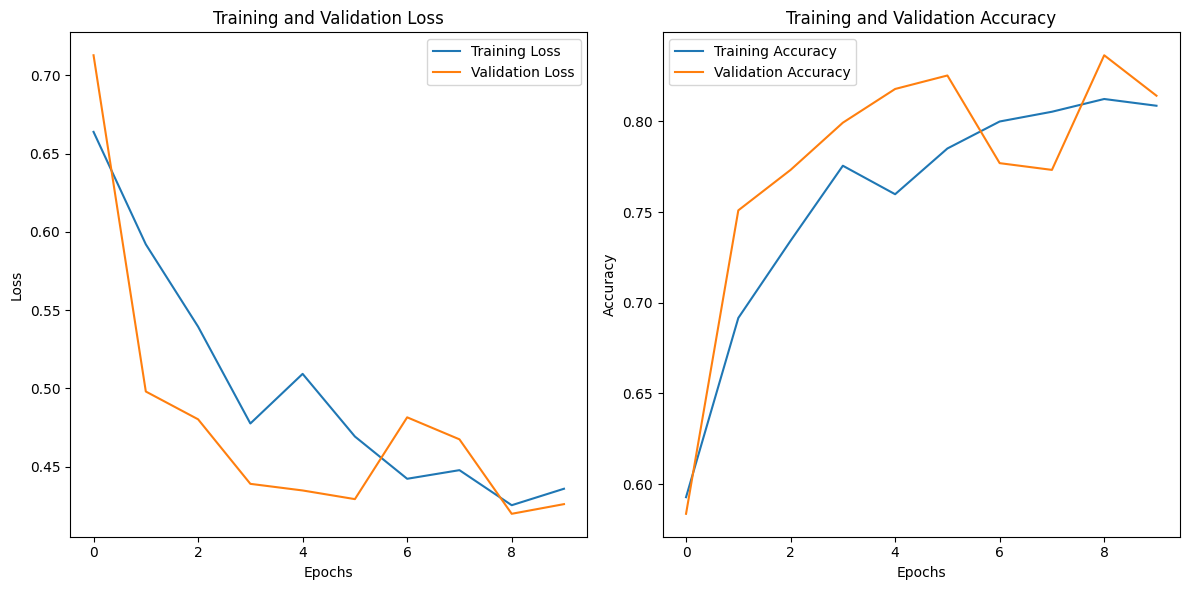

In [ ]:
# Model architecture with BiGRU
bigru_model = Sequential()
bigru_model.add(Bidirectional(GRU(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True), input_shape=(1, 768)))
bigru_model.add(Bidirectional(GRU(units=64)))
bigru_model.add(Dropout(0.3))
bigru_model.add(Dense(32, activation='relu'))
bigru_model.add(Dropout(0.3))
bigru_model.add(Dense(1, activation='sigmoid'))

bigru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
bigru_model.summary()

bigru_history =bigru_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks = callbacks('biGRU'))
show_train_history(bigru_history, name='bigru')



#Evaluate biGRU

21/21 [==============================] - 0s 11ms/step - loss: 0.4096 - accuracy: 0.7991
Model evaluation: [0.4095735549926758, 0.7991071343421936]

21/21 [==============================] - 0s 14ms/step


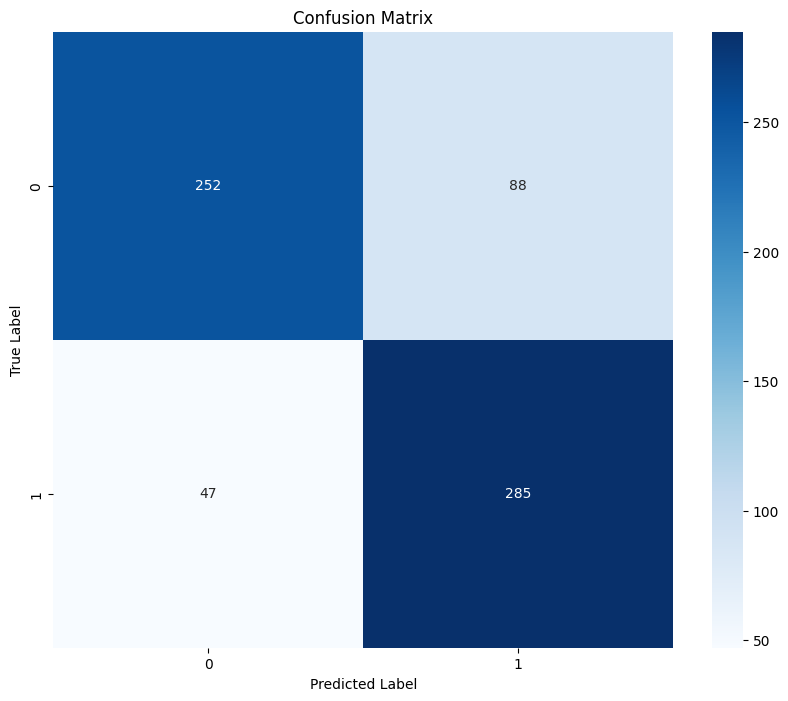


Classification report of Confusion matrix:
               precision    recall  f1-score   support

           0       0.84      0.74      0.79       340
           1       0.76      0.86      0.81       332

    accuracy                           0.80       672
   macro avg       0.80      0.80      0.80       672
weighted avg       0.80      0.80      0.80       672



In [ ]:
evaluate_results(bigru_model, X_test, y_test)

#Bi-LSTM + Attention

In [ ]:
# Custom Attention layer
class Attention(tf.keras.layers.Layer):
    def __init__(self):
        super(Attention, self).__init__()
        self.dense = Dense(1)

    def call(self, inputs):
        importance = self.dense(inputs)
        attention_weights = tf.nn.softmax(importance, axis=1)
        weighted_input = tf.multiply(inputs, attention_weights)
        return weighted_input

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 64)               205056    
 nal)                                                            
                                                                 
 attention (Attention)       (None, 64)                65        
                                                                 
 dense_7 (Dense)             (None, 256)               16640     
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 10)                1290      
                                                      

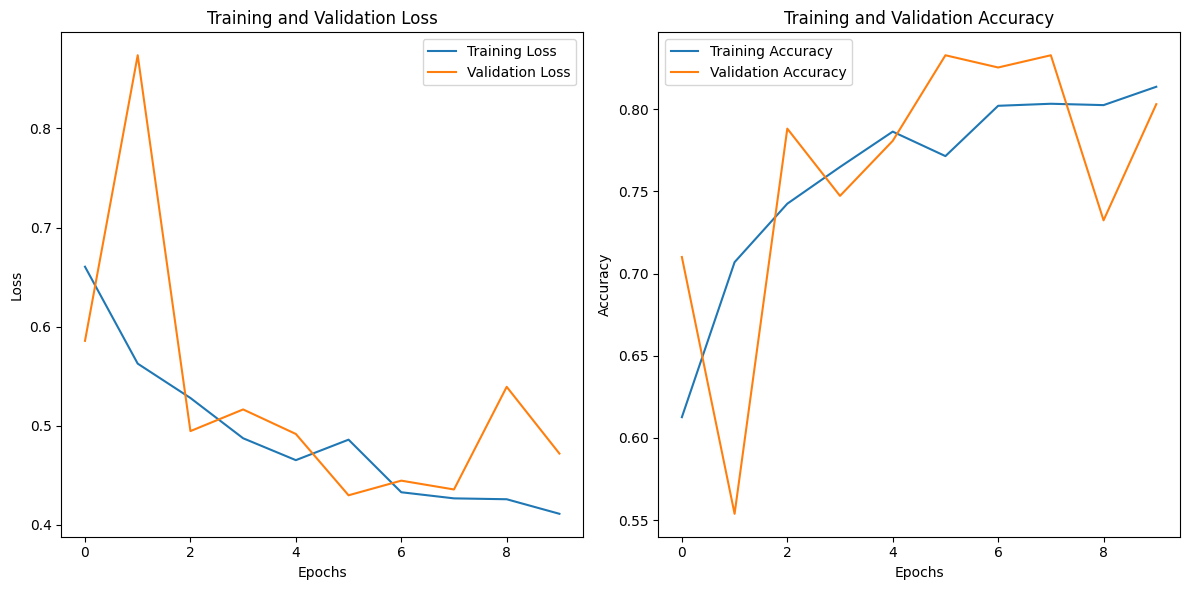

In [ ]:
def get_biLSTM_attention():
  return Sequential([
      Bidirectional(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2), input_shape=(1, 768)),
      Attention(),
      Dense(256, activation='relu'),
      Dense(128, activation='relu'),
      Dropout(0.3),
      Dense(10, activation='relu'),
      Dense(1, activation='sigmoid')
])

biLSTM_attention_model=get_biLSTM_attention()
biLSTM_attention_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
biLSTM_attention_model.summary()
history_biLSTM_attention=biLSTM_attention_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val),callbacks = callbacks('biLSTM+Attention'))
show_train_history(history_biLSTM_attention, name='biLSTM+Attenntion')

21/21 [==============================] - 0s 5ms/step - loss: 0.4565 - accuracy: 0.7946
Model evaluation: [0.45654234290122986, 0.7946428656578064]

21/21 [==============================] - 0s 3ms/step


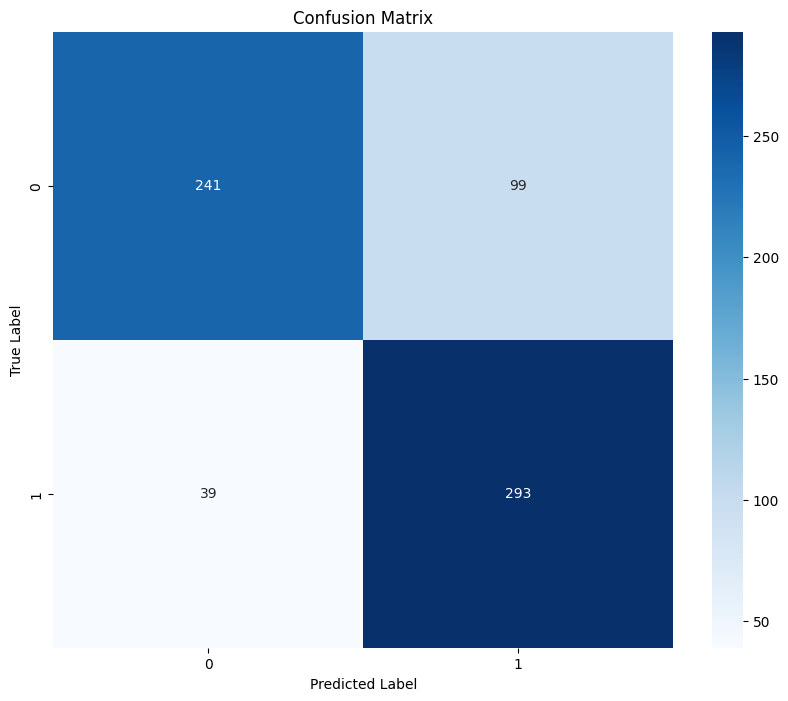


Classification report of Confusion matrix:
               precision    recall  f1-score   support

           0       0.86      0.71      0.78       340
           1       0.75      0.88      0.81       332

    accuracy                           0.79       672
   macro avg       0.80      0.80      0.79       672
weighted avg       0.80      0.79      0.79       672



In [ ]:
evaluate_results(biLSTM_attention_model, X_test, y_test)

#Plotting comparison between models

In [ ]:
predictions_bi_lstm = bi_lstm_model.predict(X_test)
accuracy_bi_lstm = accuracy_score(y_test, predictions_bi_lstm.round())

predictions_bi_lstm_attention = biLSTM_attention_model.predict(X_test)
binary_predictions_bi_lstm_attention = np.round(predictions_bi_lstm_attention).flatten().astype(int)
accuracy_bi_lstm_attention = accuracy_score(y_test, binary_predictions_bi_lstm_attention)

predictions_bigru = bigru_model.predict(X_test)
binary_predictions_bigru = np.round(predictions_bigru).flatten().astype(int)
accuracy_bigru = accuracy_score(y_test, binary_predictions_bigru)

conclusion = pd.DataFrame({'Models': ['BiLSTM', 'BiGRU', 'Bi-LSTM+Attention'], 'Accuracy': [accuracy_bi_lstm,accuracy_bigru, accuracy_bi_lstm_attention]})
conclusion['Accuracy'] = conclusion['Accuracy'].apply(lambda x: round(x, 2))
conclusion.sort_values(by='Accuracy', inplace=True, ascending=False)


21/21 [==============================] - 0s 4ms/step


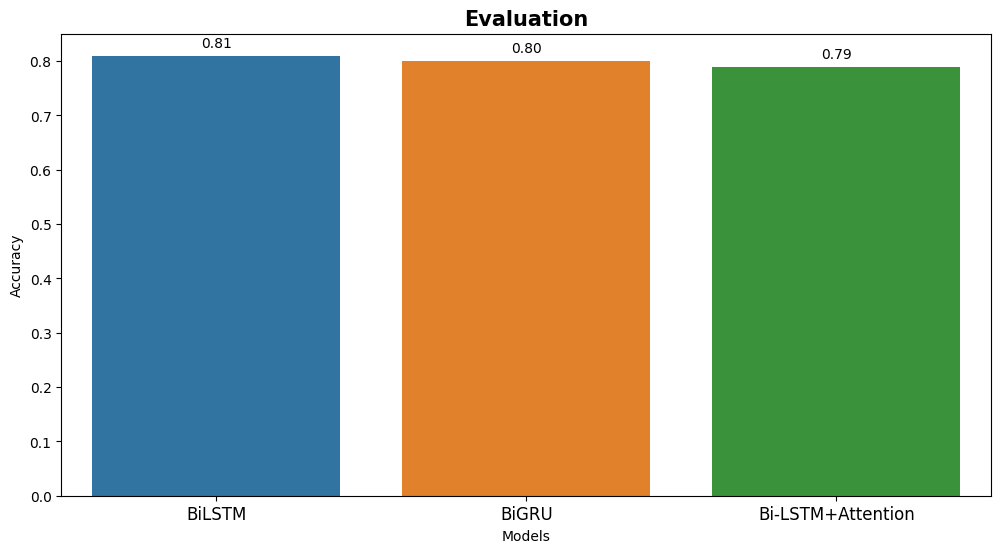

In [ ]:
# Plot the accuracy comparison
plt.figure(figsize=(12, 6))
seaborn_plot = sns.barplot(x='Models', y='Accuracy', data=conclusion)
for p in seaborn_plot.patches:
    seaborn_plot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                          va='center', xytext=(0, 9), textcoords='offset points')
plt.title("Evaluation", weight='bold', size=15)
plt.xticks(size=12)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.show()